In [3]:
import pandas as pd
import numpy as np
import folium
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Preamble/Summary

The following is some scrap work related to trying to build models based of what I called the "max impulse" of a given device reading -- the absolute value sum of accelerometer readings over the most active 30 seconds recorded by a given device in an earthquake's timeframe. Attempts were made to predict latitude, longitude and magnitude.

In a desperate attempt to find something that worked, I also restricted the problem to the three most seismically active states, and tried convert the problem to a classification model to see if any results were obtainable by just guessing if an earthquake was in a given state. This also mostly just returned the mean/baseline.

# Unedited scrap work

In [4]:
impulse_df=pd.read_pickle('..\..\data\pickled_files\\impulse_df.p')

In [5]:
impulse_df

,magnitude,latitude,longitude,depth,Referencia de localizacion,utc_datetime,outlier,device_1,device_2,device_4,...,device_22,device_23,device_24,device_26,device_27,device_29,device_33,device_999,state,state_lab
0,7.4,15.8033,-96.1337,22.8,"4 km al NORTE de CRUCECITA, OAX",2020-06-23 15:29:03,0,148.140313,110.446250,37.233750,...,0.000000,0.000000,11.426875,0.000000,0.000000,0.00000,0.0,0.000000,OAX,10
1,7.2,16.2180,-98.0135,16.0,"14 km al SURESTE de PINOTEPA NACIONAL, OAX",2018-02-16 23:39:39,0,41.756625,0.000000,0.000000,...,0.000000,14.644406,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,OAX,10
2,6.5,14.5818,-92.4807,76.2,"37 km al SUROESTE de CD HIDALGO, CHIS",2019-02-01 16:14:12,0,20.434688,5.175312,7.550000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,6.707500,CHIS,3
3,6.4,13.7792,-93.3382,9.4,"162 km al SUROESTE de CD HIDALGO, CHIS",2019-11-20 04:27:06,0,1.020000,0.000000,0.000000,...,0.000000,0.000000,1.024375,0.000000,1.265937,1.05625,0.0,0.000000,CHIS,3
4,6.3,26.6672,-111.0790,16.1,"77 km al NORESTE de LORETO, BCS",2018-01-19 16:17:45,1,6.183687,0.000000,0.000000,...,11.411563,11.090406,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,BCS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.3,15.5190,-94.9390,21.5,"78 km al SURESTE de SALINA CRUZ, OAX",2019-03-28 09:08:36,0,18.008125,17.935000,17.329062,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,8.268438,OAX,10
996,4.3,14.5795,-93.7258,20.1,"131 km al SUROESTE de MAPASTEPEC, CHIS",2019-02-25 19:38:56,0,6.294062,11.402188,4.215313,...,0.000000,0.000000,2.317188,10.243125,0.000000,0.00000,0.0,22.031875,CHIS,3
997,4.3,14.4045,-93.9323,12.5,"160 km al SUROESTE de MAPASTEPEC, CHIS",2019-02-25 19:36:46,0,6.294062,11.627812,4.215313,...,0.000000,0.000000,2.317188,9.923438,0.000000,0.00000,0.0,22.031875,CHIS,3
998,4.3,19.0497,-107.4690,10.0,"291 km al SUROESTE de PUERTO VALLARTA, JAL",2019-03-30 06:54:28,0,11.543438,13.703125,19.907500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,JAL,8


Idea: Using just the max impulses calculated, see if we can get anywhere with random forests, adaboost, or support vector machines.

In [3]:
impulse_df['state']

0       OAX
1       OAX
2      CHIS
3      CHIS
4       BCS
       ... 
995     OAX
996    CHIS
997    CHIS
998     JAL
999    CHIS
Name: state, Length: 1000, dtype: object

In [5]:
subset = impulse_df[impulse_df['state'].isin(['OAX','CHIS','GRO'])]

Due to the spastic nature of this data, my first hunch would be to try a random forest model. Maybe KNN might do something because the outputs should be clustered?

In [6]:
device_cols=impulse_df.columns[impulse_df.columns.str.startswith('device')]

In [7]:
subset['state_lab']=subset['state_lab'].map({10:0, 3: 1, 7: 2})

<ipython-input-7-b11b31a2021d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['state_lab']=subset['state_lab'].map({10:0, 3: 1, 7: 2})


In this case, we're going to have to train one model each for latitude and longitude.

In [9]:
X=subset[device_cols]
y=subset['state_lab']

In [57]:
X

,device_1,device_2,device_4,device_5,device_6,device_7,device_8,device_9,device_10,device_11,...,device_20,device_21,device_22,device_23,device_24,device_26,device_27,device_29,device_33,device_999
0,148.140313,110.446250,37.233750,143.483437,34.835625,133.800938,0.817500,0.894062,20.766562,17.304375,...,11.315000,0.000000,0.0,0.000000,11.426875,0.000000,0.000000,0.000000,0.0,0.000000
1,41.756625,0.000000,0.000000,0.000000,110.759281,0.000000,68.813906,75.440250,47.495062,36.014906,...,29.755156,0.000000,0.0,14.644406,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,20.434688,5.175312,7.550000,0.000000,10.562188,14.421563,0.000000,15.708750,0.000000,6.856875,...,6.847500,17.646563,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.707500
3,1.020000,0.000000,0.000000,4.010625,0.000000,0.000000,0.000000,1.047500,0.000000,0.852188,...,0.000000,0.930938,0.0,0.000000,1.024375,0.000000,1.265937,1.056250,0.0,0.000000
6,2.559375,5.543437,1.733125,41.744375,1.293750,26.040313,0.000000,1.230625,1.137813,1.069688,...,1.023438,1.068437,0.0,0.000000,1.087187,0.000000,2.442813,1.619687,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,11.860938,8.685938,11.590000,0.000000,16.694688,25.694688,0.000000,0.000000,0.000000,3.877500,...,9.427500,0.000000,0.0,0.000000,0.000000,6.466875,0.000000,0.000000,0.0,8.072188
995,18.008125,17.935000,17.329062,0.000000,18.256250,27.493750,0.000000,0.000000,0.000000,3.447813,...,7.515625,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,8.268438
996,6.294062,11.402188,4.215313,0.000000,7.106250,6.909375,3.107813,31.665000,0.000000,2.740625,...,3.689375,5.931250,0.0,0.000000,2.317188,10.243125,0.000000,0.000000,0.0,22.031875
997,6.294062,11.627812,4.215313,0.000000,6.974688,7.057500,3.107813,31.667813,0.000000,2.740625,...,3.643438,5.937812,0.0,0.000000,2.317188,9.923438,0.000000,0.000000,0.0,22.031875


In [60]:
X_norm=normalize(X)

0    378
1    335
2    105
Name: state_lab, dtype: int64

In [91]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

In [16]:
y_train.value_counts()

0    302
1    268
2     84
Name: state_lab, dtype: int64

<AxesSubplot:xlabel='latitude', ylabel='Count'>

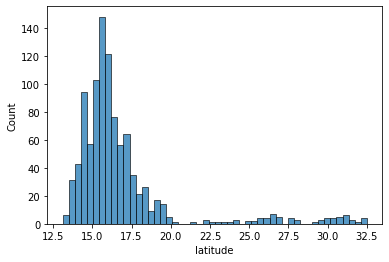

In [13]:
sns.histplot(data=impulse_df, x='latitude')

In [14]:
X.describe()

,device_1,device_2,device_4,device_5,device_6,device_7,device_8,device_9,device_10,device_11,...,device_20,device_21,device_22,device_23,device_24,device_26,device_27,device_29,device_33,device_999
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,...,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,6.373918,4.711915,5.517415,2.719043,6.430978,4.085222,3.449562,10.400807,2.274371,4.194175,...,5.586605,3.758136,2.223602,2.303275,3.363719,0.596010,0.228086,0.190874,0.085958,3.694567
std,8.849757,7.028904,7.572259,6.328665,9.021029,7.488207,7.256239,18.871107,4.723316,5.793582,...,7.325675,4.631357,5.828199,3.297809,7.050860,7.278839,0.424677,0.386587,0.275461,5.904506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.925938,0.000000,0.885703,0.000000,0.960000,0.000000,0.000000,0.943281,0.000000,0.900938,...,0.945859,0.887031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.123438,1.009688,0.975469,0.958438,2.754500,0.978125,0.882969,1.078594,0.000000,1.012656,...,2.233172,1.011406,0.000000,0.000000,0.995625,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.623055,7.669250,9.838883,3.364320,8.836031,6.388562,3.884523,11.363859,1.061875,5.331656,...,8.016906,6.190875,0.000000,4.373219,2.868945,0.000000,0.000000,0.000000,0.000000,6.147234
max,148.140313,110.446250,45.206156,143.483437,110.759281,133.800938,68.813906,116.009125,47.495062,36.014906,...,42.974375,21.066875,36.665437,15.729281,51.194688,155.416875,2.652188,1.619687,1.765312,29.554156


device_6       51
device_11      81
device_1       95
device_20     105
device_14     109
device_15     151
device_9      196
device_4      199
device_21     227
device_2      250
device_5      252
device_24     285
device_7      356
device_8      406
device_10     466
device_18     506
device_13     506
device_16     526
device_999    529
device_17     541
device_23     558
device_19     699
device_27     712
device_29     744
device_12     763
device_22     768
device_33     844
device_26     867
dtype: int64

In [72]:
X

,device_1,device_2,device_4,device_5,device_6,device_7,device_8,device_9,device_10,device_11,...,device_20,device_21,device_22,device_23,device_24,device_26,device_27,device_29,device_33,device_999
0,148.140313,110.446250,37.233750,143.483437,34.835625,133.800938,0.817500,0.894062,20.766562,17.304375,...,11.315000,0.000000,0.0,0.000000,11.426875,0.000000,0.000000,0.000000,0.0,0.000000
1,41.756625,0.000000,0.000000,0.000000,110.759281,0.000000,68.813906,75.440250,47.495062,36.014906,...,29.755156,0.000000,0.0,14.644406,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,20.434688,5.175312,7.550000,0.000000,10.562188,14.421563,0.000000,15.708750,0.000000,6.856875,...,6.847500,17.646563,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.707500
3,1.020000,0.000000,0.000000,4.010625,0.000000,0.000000,0.000000,1.047500,0.000000,0.852188,...,0.000000,0.930938,0.0,0.000000,1.024375,0.000000,1.265937,1.056250,0.0,0.000000
6,2.559375,5.543437,1.733125,41.744375,1.293750,26.040313,0.000000,1.230625,1.137813,1.069688,...,1.023438,1.068437,0.0,0.000000,1.087187,0.000000,2.442813,1.619687,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,18.008125,17.935000,17.329062,0.000000,18.256250,27.493750,0.000000,0.000000,0.000000,3.447813,...,7.515625,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,8.268438
996,6.294062,11.402188,4.215313,0.000000,7.106250,6.909375,3.107813,31.665000,0.000000,2.740625,...,3.689375,5.931250,0.0,0.000000,2.317188,10.243125,0.000000,0.000000,0.0,22.031875
997,6.294062,11.627812,4.215313,0.000000,6.974688,7.057500,3.107813,31.667813,0.000000,2.740625,...,3.643438,5.937812,0.0,0.000000,2.317188,9.923438,0.000000,0.000000,0.0,22.031875
998,11.543438,13.703125,19.907500,0.000000,8.586875,5.420000,0.000000,16.689688,0.000000,6.817813,...,11.095000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [117]:
rf=RandomForestClassifier()

rf_params={'n_estimators':[50,100,150,200],
        'max_depth':[1,3,5],
    'min_samples_leaf': [1,2,5,10]
           }

gs_rf=GridSearchCV(rf, rf_params, cv=5, verbose=1, n_jobs=6)

In [118]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:   14.6s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'max_depth': [1, 3, 5],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [119]:
gs_rf.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 150}

In [120]:
gs_rf.best_score_

0.5504991192014093

In [121]:
gs_rf.score(X_train, y_train)

0.7629969418960245

In [122]:
gs_rf.score(X_test, y_test)

0.5060975609756098

In [29]:
gs_rf.predict(X_train)

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 0, 1, 0, 0,

In [44]:
rf=RandomForestRegressor()

In [45]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [46]:
rf.score(X_train, y_train)

0.8526660984629905

In [48]:
rf.score(X_test, y_test)

0.024309834116766682

In [36]:
ar=AdaBoostClassifier(base_estimator=DecisionTreeRegressor())


ar_params={'n_estimators':[50,100,150,200, 250, 300, 350, 400, 450, 500],
          'base_estimator__max_depth':[1, 3]}

gs_ar=GridSearchCV(ar, ar_params, cv=5, verbose=1, n_jobs=6)

In [37]:
gs_ar.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  80 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    1.0s finished


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),
             n_jobs=6,
             param_grid={'base_estimator__max_depth': [1, 3],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             verbose=1)

In [38]:
gs_ar.best_score_

0.03260014674682536

In [33]:
gs_ar.best_params_

{'base_estimator__max_depth': 1, 'n_estimators': 250}

In [34]:
gs_ar.score(X_train, y_train)

0.036684433625681856

In [35]:
gs_ar.score(X_test, y_test)

-0.023454775215803636

Did my imputation wreck things? Let's take the 5 most filled in columns, drop the 0 vals and see if we can get anything.

In [77]:
X[X[device_cols] > 0 ].isna().sum().sort_values()

device_6       51
device_11      81
device_1       95
device_20     105
device_14     109
device_15     151
device_9      196
device_4      199
device_21     227
device_2      250
device_5      252
device_24     285
device_7      356
device_8      406
device_10     466
device_18     506
device_13     506
device_16     526
device_999    529
device_17     541
device_23     558
device_19     699
device_27     712
device_29     744
device_12     763
device_22     768
device_33     844
device_26     867
dtype: int64

In [86]:
subsample= no_outliers[['device_6', 'device_11', 'device_1', "device_20", "device_14", 'latitude', 'longitude', 'magnitude']]

In [89]:
for device in ['device_6', 'device_11', 'device_1', "device_20", "device_14"]:
    subsample[device]=subsample[device].map(lambda x: x if x > 0 else None)

<ipython-input-89-27ddb31e49a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsample[device]=subsample[device].map(lambda x: x if x > 0 else None)


In [93]:
full_subsample=subsample.dropna()

In [97]:
full_subsample.describe()

,device_6,device_11,device_1,device_20,device_14,latitude,longitude,magnitude
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,6.882839,4.701152,7.261176,6.093053,3.745196,15.963053,-96.249957,4.589661
std,9.522424,5.772285,9.771668,7.405698,3.679238,1.402465,3.843337,0.361248
min,0.866250,0.809063,0.842187,0.854688,0.834688,13.103500,-109.432000,4.300000
25%,0.967500,0.922813,0.949688,0.963750,0.947188,14.989000,-98.123200,4.400000
50%,4.516312,2.733719,4.802500,3.485344,2.289688,15.791700,-94.903800,4.500000
75%,8.743094,5.903750,10.582188,8.329625,5.624219,16.866500,-93.674000,4.700000
max,110.759281,36.014906,148.140313,42.974375,30.070469,20.446300,-91.589200,7.400000


In [94]:
X=full_subsample.drop(columns=['latitude', 'longitude', 'magnitude'])

In [95]:
y_lat=full_subsample['latitude']
y_long=full_subsample['longitude']
y_mag=full_subsample['magnitude']

In [112]:
X_train, X_test, y_train, y_test= train_test_split(X, y_mag, test_size=0.2, random_state=69)

In [113]:
rf=RandomForestRegressor()

rf_params={'n_estimators':[25,50,100],
        'max_depth':[None, 5, 10],
    'min_samples_split': [2,4, 10],
    'min_samples_leaf': [1,2,5,10],
           }

gs_rf=GridSearchCV(rf, rf_params, cv=5, verbose=1, n_jobs=6)

In [114]:
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:    9.1s
[Parallel(n_jobs=6)]: Done 540 out of 540 | elapsed:   13.6s finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=6,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [25, 50, 100]},
             verbose=1)

In [115]:
gs_rf.best_score_

0.008000771171572408

In [116]:
gs_rf.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [117]:
gs_rf.score(X_train, y_train)

0.36728456676657495

In [118]:
gs_rf.score(X_test, y_test)

0.04831186122717335

In [41]:
ac=AdaBoostClassifier()


ac_params={'n_estimators':[50,100,150,200, 250, 300, 350, 400, 450, 500]}

gs_ac=GridSearchCV(ac, ac_params, cv=5, verbose=1, n_jobs=6)

In [42]:
gs_ac.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    8.0s finished


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=6,
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             verbose=1)

In [43]:
gs_ac.best_params_

{'n_estimators': 450}

In [45]:
gs_ac.best_score_

0.5443687610099823

In [46]:
gs_ac.score(X_train, y_train)

0.764525993883792

In [47]:
gs_ac.score(X_test, y_test)

0.3780487804878049

In [50]:
svc=SVC()

svc_params={'kernel':['poly','rbf'],
          'degree':[3,5],
            'coef0':[0, 1],
           }

gs_svc=GridSearchCV(svc, svc_params, cv=5, verbose=10, n_jobs=8)

In [51]:
gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1839s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  30 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  35 out of  40 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.6s finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=8,
             param_grid={'coef0': [0, 1], 'degree': [3, 5],
                         'kernel': ['poly', 'rbf']},
             verbose=10)

In [52]:
gs_svc.best_params_

{'coef0': 0, 'degree': 3, 'kernel': 'rbf'}

In [53]:
gs_svc.best_score_

0.46178508514386374

In [54]:
gs_svc.score(X_train, y_train)

0.4617737003058104

In [55]:
gs_svc.score(X_test, y_test)

0.4634146341463415